# Spectral Cluster Counting

Trying to count coincidences based on the histogram information.

In [1]:
# import libraries
import raadpy as rp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

Warning! Cupy not found! GPU accelleration is not available



In [2]:
# Define some constants
raw_dir = '../../Data/FULL_DATA/JAN/'
TIME    = 1e-3

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-2022-03-04-buff1.dat', 'buff2': 'light1-2022-08-04-buff2.dat', 'buff3': 'light1-2022-08-02-buff3.dat', 'buff4': 'light1-2022-03-04-buff4.dat', 'buff5': 'light1-2022-03-04-buff5.dat', 'buff6': 'light1-2022-03-08-buff6.dat', 'buff7': 'light1-2022-03-08-buff7.dat', 'log': 'RAAD-0-log.txt'}


# Plot the orbit data

An overarching view of the dataset

In [3]:
# Plot the orbit data for this run
buffer_fname    = raw_dir + filenames['buff1']
fname           = buffer_fname.split('/')[-1]

# Decode the buffer data in a dictionary
data_SiPM   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 1",LAST=40000)
data_PMT    = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 0",LAST=40000)

The length of the file is 349101 lines.


Line:   0%|          | 0/40000 [00:00<?, ?it/s]

The length of the file is 349101 lines.


Line:   0%|          | 0/40000 [00:00<?, ?it/s]

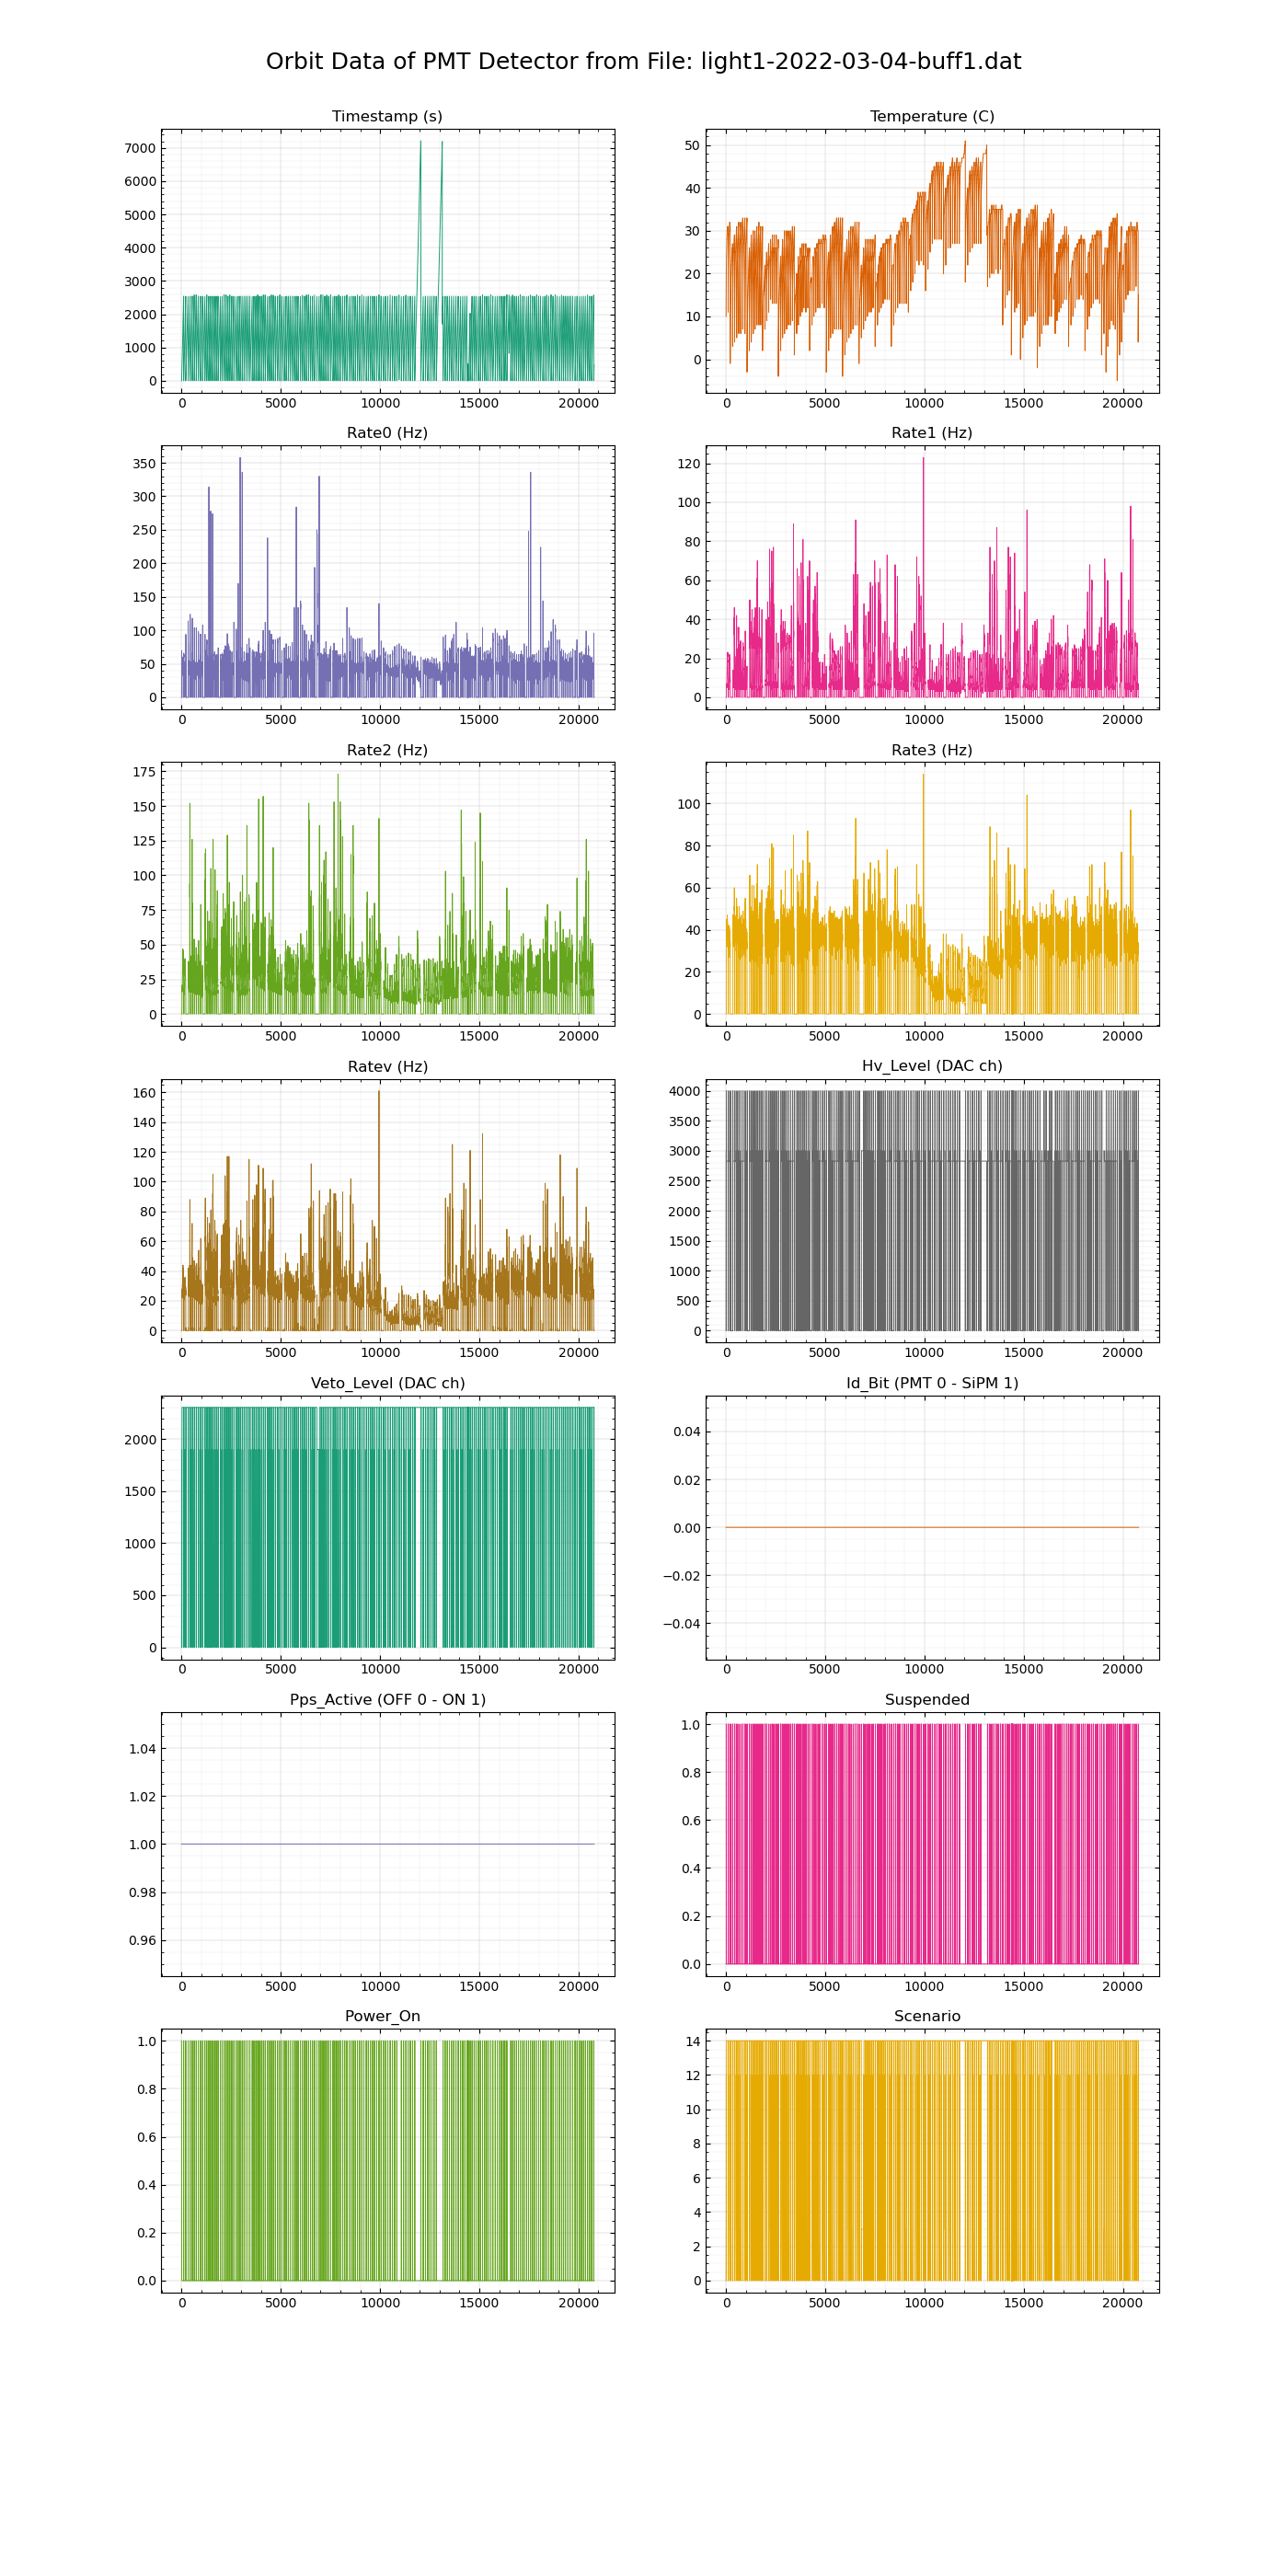

In [4]:
# PMT
fig, axes  = rp.plot_buffer(data_PMT,title = 'Orbit Data of PMT Detector from File: '+ fname,UNITS=rp.ORBIT_UNITS)

# Pick a buffer and display it

Then get a buffer corresponding to this orbit data and plot it.


- BUFFER 1 - Orbit Data
- BUFFER 2 - TGF SiPM
- BUFFER 3 - TGF PMT
- BUFFER 4 - Non Veto SiPM
- BUFFER 5 - Non Veto PMT
- BUFFER 6 - Veto SiPM
- BUFFER 7 - Veto PMT
- BUFFER 8 - Reserved SiPM
- BUFFER 9 - Reserved PMT

In [43]:
# NONVETO BUFFERS
# Decode the buffer data in a dictionary
# data         = rp.get_dict(raw_dir+filenames['buff7'],struct=rp.VETO_STRUCT,STUPID=True,VERIFY=True,threshold=3e7,START_LINE=10200000, END_LINE=11000000)
data = rp.get_dict(raw_dir+filenames['buff5'],struct=rp.NONVETO_STRUCT,VERIFY=True,STUPID=True,threshold=4*1e6,LAST=5000000)


The length of the file is 203538194 lines.


Line:   0%|          | 0/5000000 [00:00<?, ?it/s]

Bit Flipper:   0%|          | 0/4999999 [00:00<?, ?it/s]

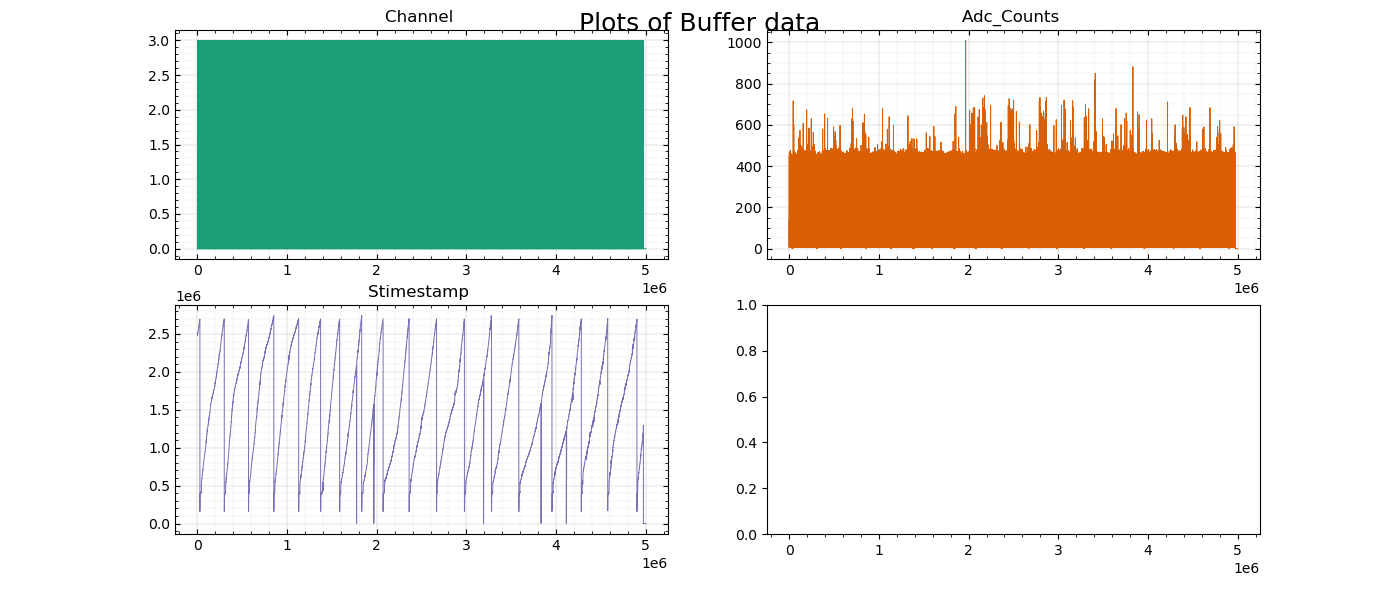

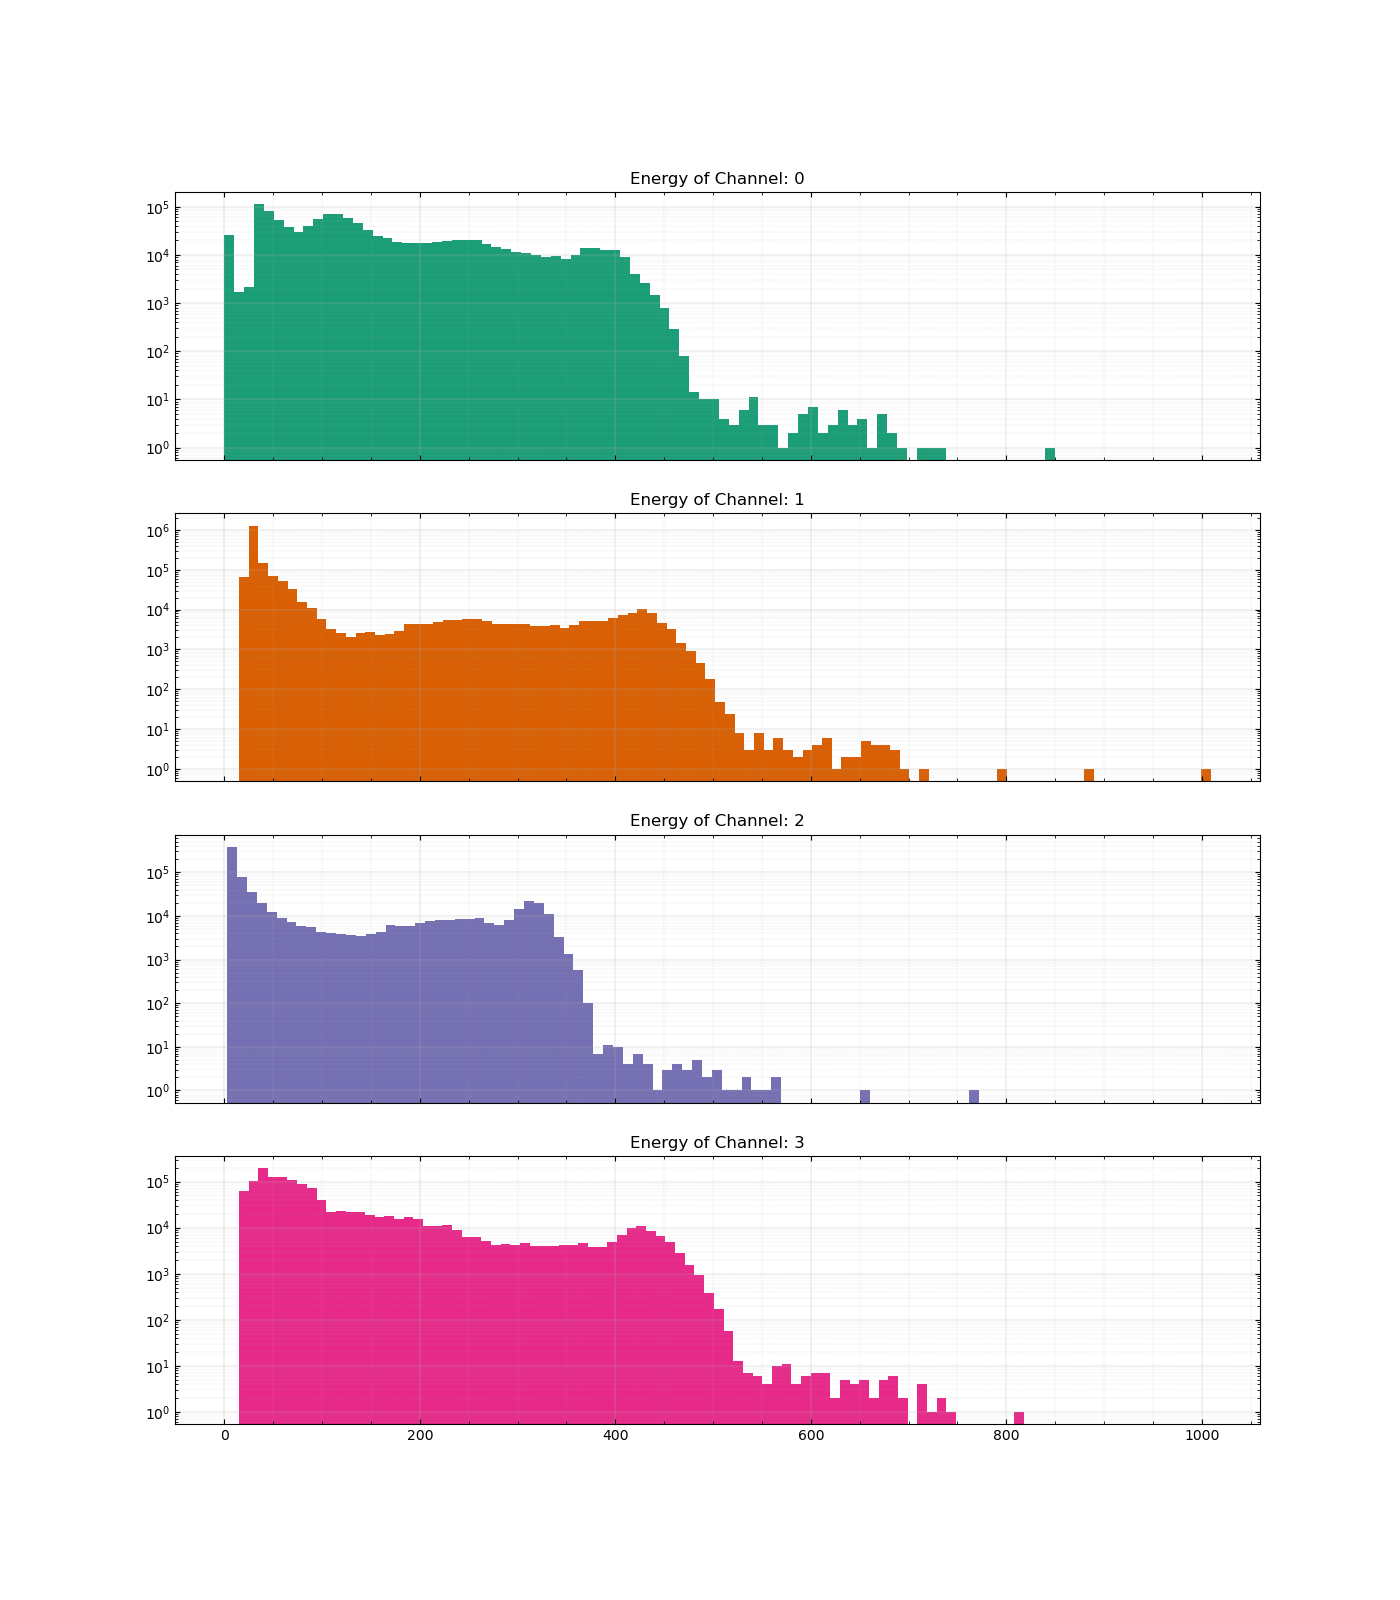

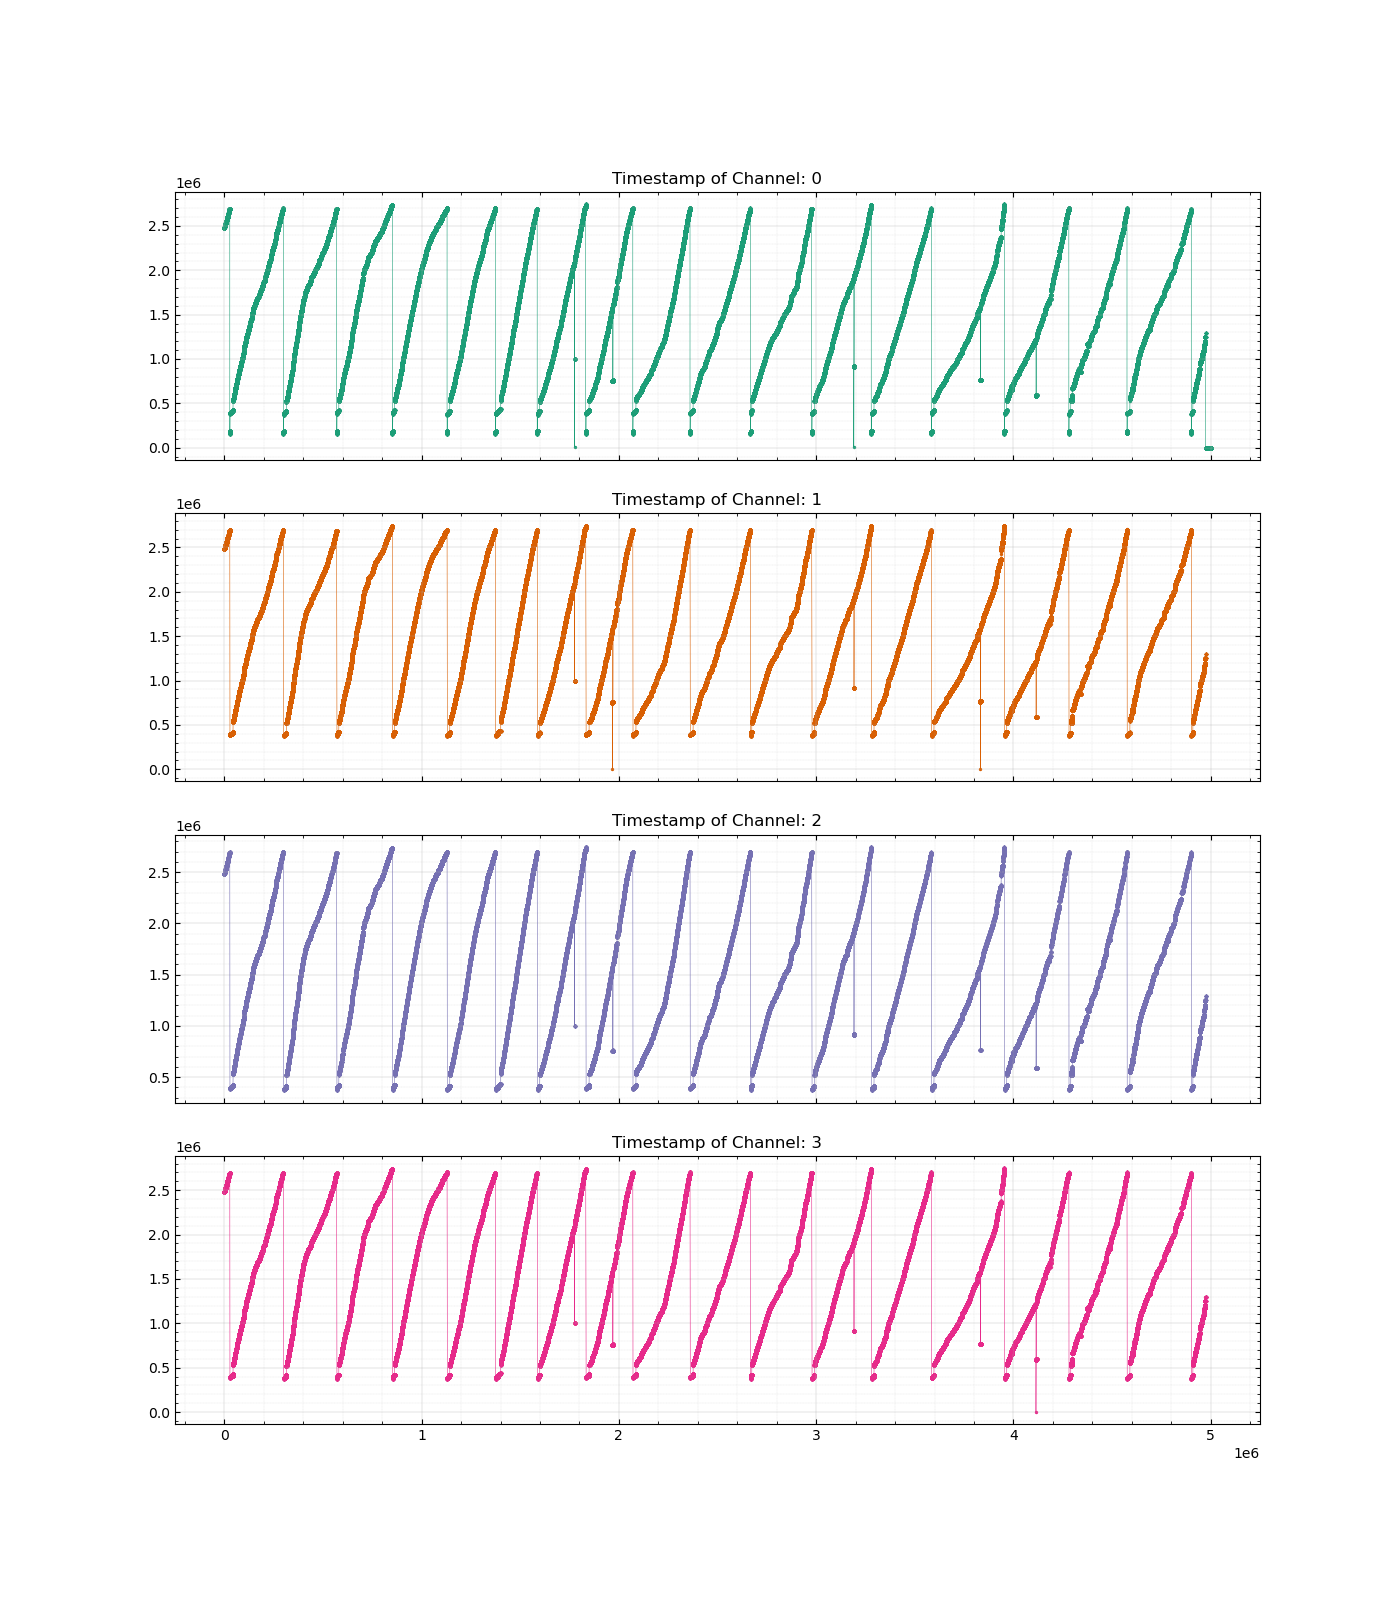

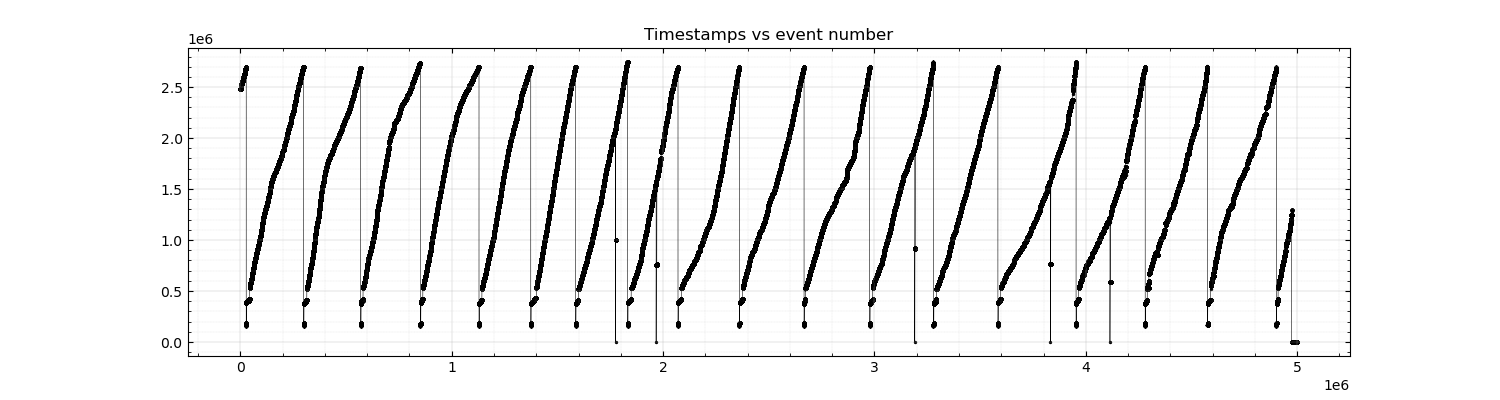

In [45]:
# Plot the buffers details

# Plot the data as well
rp.plot_buffer(data);

# Histograms
rp.plot_hists(data, rp.NONVETO_STRUCT, bins=100);

# Timestamps
rp.plot_timestamps(data, rp.NONVETO_STRUCT);

# Full timestamp
rp.plot_timestamp(data);

In [31]:
from nfft import ndft
N = 50000
S = 10*56000
# transform = ndft(data['stimestamp'][:N],data['adc_counts'][:N])
transform = np.fft.fft(data['adc_counts'][:S+N])
# N = int(len(data['stimestamp']))
frequency = np.fft.fftfreq(N,10./N)

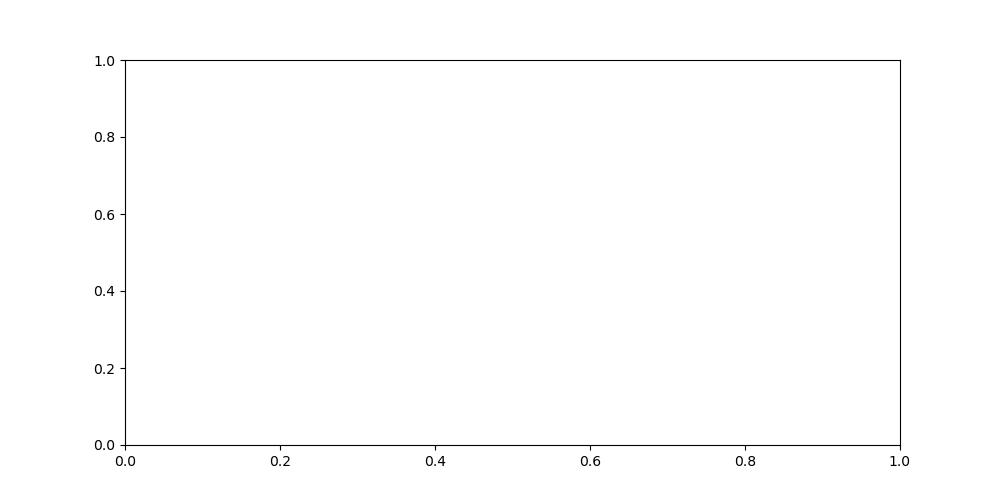

In [41]:
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

# ax.plot(frequency[:N//2], np.abs(transform)[:N//2])
# ax.set_yscale('log')
channels = rp.split_channels(data,rp.VETO_STRUCT)
# ax.scatter(np.arange(N),channels[0]['adc_counts'][:N],s=1,alpha=0.2) #data['stimestamp'][:N]


# Now perform the analysis

First we collect data from multiple files

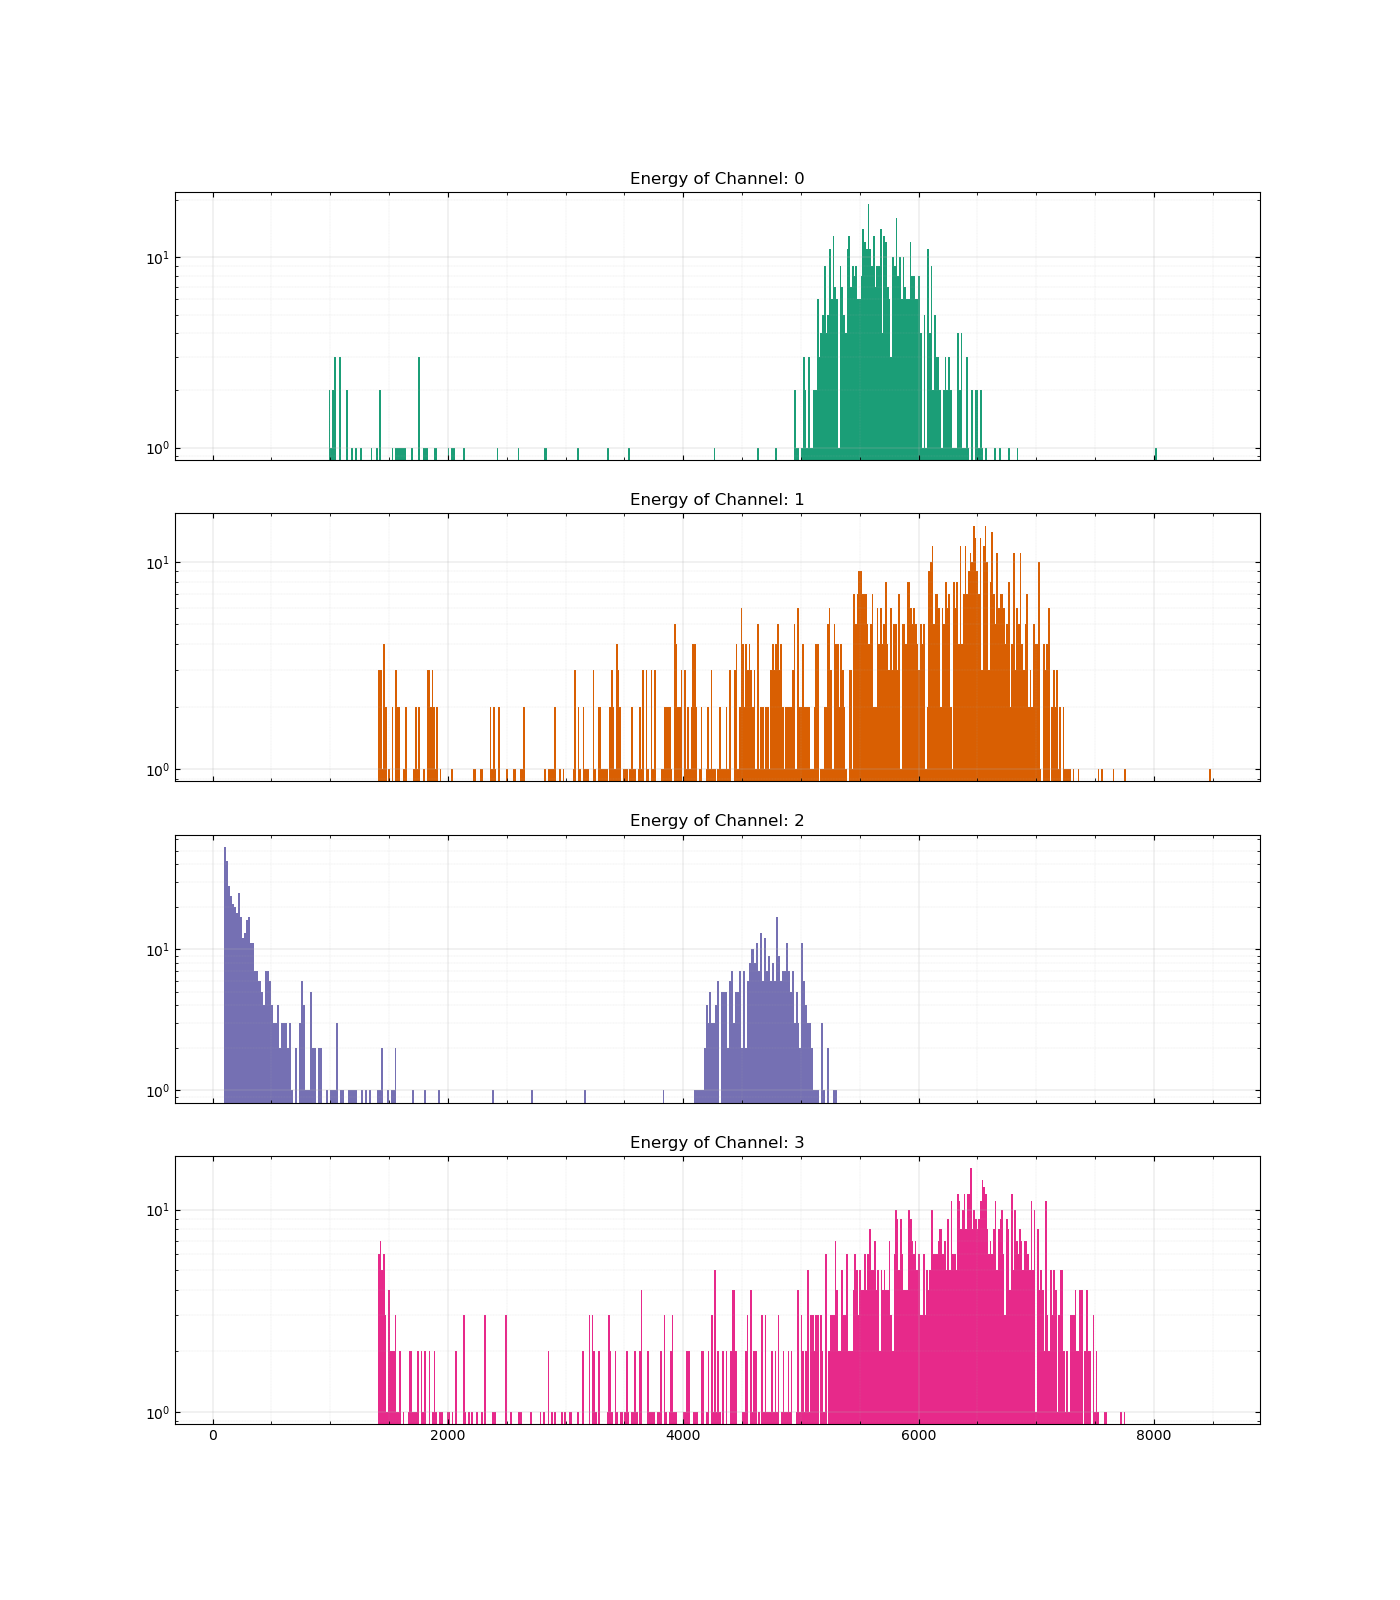

In [9]:
# Plot the histograms
s = lambda x: sum([int(i) for i in "{0:b}".format(int(x))])     # Get the veto string and find the number of scintillators triggered
num = np.array([s(x) for x in data['veto']])                    # Find the number of scintillators triggered for each event
idx = np.where(num==4)[0]                                       # Give me the indices where the number of triggered scintillators is num.
dat = rp.dict_subsec(data,idx)                                  # Get the dubset of data that triggered this many scintillators

fig, ax = rp.plot_hists(dat, rp.VETO_STRUCT,bins=501)           # PLOT

In [10]:
def detector_illustration(veto_mask:int=None,channel=None,LINE:bool=False):
    # Create a diagram of the payload
    fig = plt.figure(figsize=(3,3),dpi=170)
    ax  = fig.add_subplot(111)
    ax.set_axis_off()

    # Create the layout
    length      = 1
    padding     = 3e-2*length
    veto_side   = 1e-1*length
    cryst_side  = (length - 5*padding - 2*veto_side)/2

    # Create the vetos
    veto = [
        patches.Rectangle((padding,3*padding+veto_side+cryst_side), veto_side, cryst_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),
        patches.Rectangle((padding,2*padding+veto_side), veto_side, cryst_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),

        patches.Rectangle((2*padding+veto_side,padding), cryst_side, veto_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),
        patches.Rectangle((3*padding+veto_side+cryst_side,padding), cryst_side, veto_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),

        patches.Rectangle((4*padding+veto_side+2*cryst_side,2*padding+veto_side), veto_side, cryst_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),
        patches.Rectangle((4*padding+veto_side+2*cryst_side,3*padding+veto_side+cryst_side), veto_side, cryst_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),

        patches.Rectangle((3*padding+veto_side+cryst_side,4*padding + veto_side + 2*cryst_side), cryst_side, veto_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),
        patches.Rectangle((2*padding+veto_side,4*padding + veto_side + 2*cryst_side), cryst_side, veto_side, linewidth=1, edgecolor='deepskyblue', facecolor='none'),
    ]

    crystals = [
        patches.Rectangle((2*padding + veto_side,3*padding+veto_side + cryst_side), cryst_side, cryst_side, linewidth=1, edgecolor='k', facecolor='none'),
        patches.Rectangle((2*padding + veto_side,2*padding+veto_side), cryst_side, cryst_side, linewidth=1, edgecolor='k', facecolor='none'),
        patches.Rectangle((3*padding + veto_side + cryst_side,2*padding+veto_side), cryst_side, cryst_side, linewidth=1, edgecolor='k', facecolor='none'),
        patches.Rectangle((3*padding + veto_side + cryst_side,3*padding+veto_side + cryst_side), cryst_side, cryst_side, linewidth=1, edgecolor='k', facecolor='none'),
    ]

    # Light up the detectors hit with the veto mask
    if veto_mask is not None:
        detectors = decode_veto(veto_mask)

        for d in detectors: veto[d].set_facecolor('deepskyblue')

        # If you want to add a line
        if LINE:
            # Create the effect of the particle passing through
            a = detectors[0]
            b = detectors[1]

            # Add the line
            point_a = np.mean(veto[a].get_bbox().corners(),axis=0)
            point_b = np.mean(veto[b].get_bbox().corners(),axis=0)
            ax.axline(point_a,point_b, c = 'k',ls=':')

            # Change the colors
            veto[a].set_facecolor('deepskyblue')
            veto[b].set_facecolor('deepskyblue')

    
    # Light up the channel
    if channel is not None:
        crystals[channel].set_facecolor('darkgrey')



    for v in veto: ax.add_patch(v)
    for c in crystals: ax.add_patch(c)

    return fig,ax

# We also want to get the detectors from a string and vice versa
def decode_veto(mask:int):
    arr = np.array([int(i) for i in "{0:b}".format(int(mask))])
    return len(arr) - 1 - np.where(arr==1)[0]

def encode_veto(detectors):
    return np.sum([2**i for i in detectors])

# Fiilter data according to mask
def mask_filter(mask:int,data):
    idx = np.where(data['veto'] == mask)
    return {key:data[key][idx] for key in data.keys()}

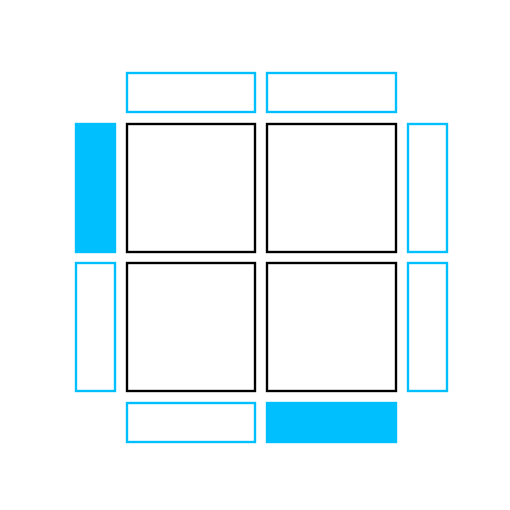

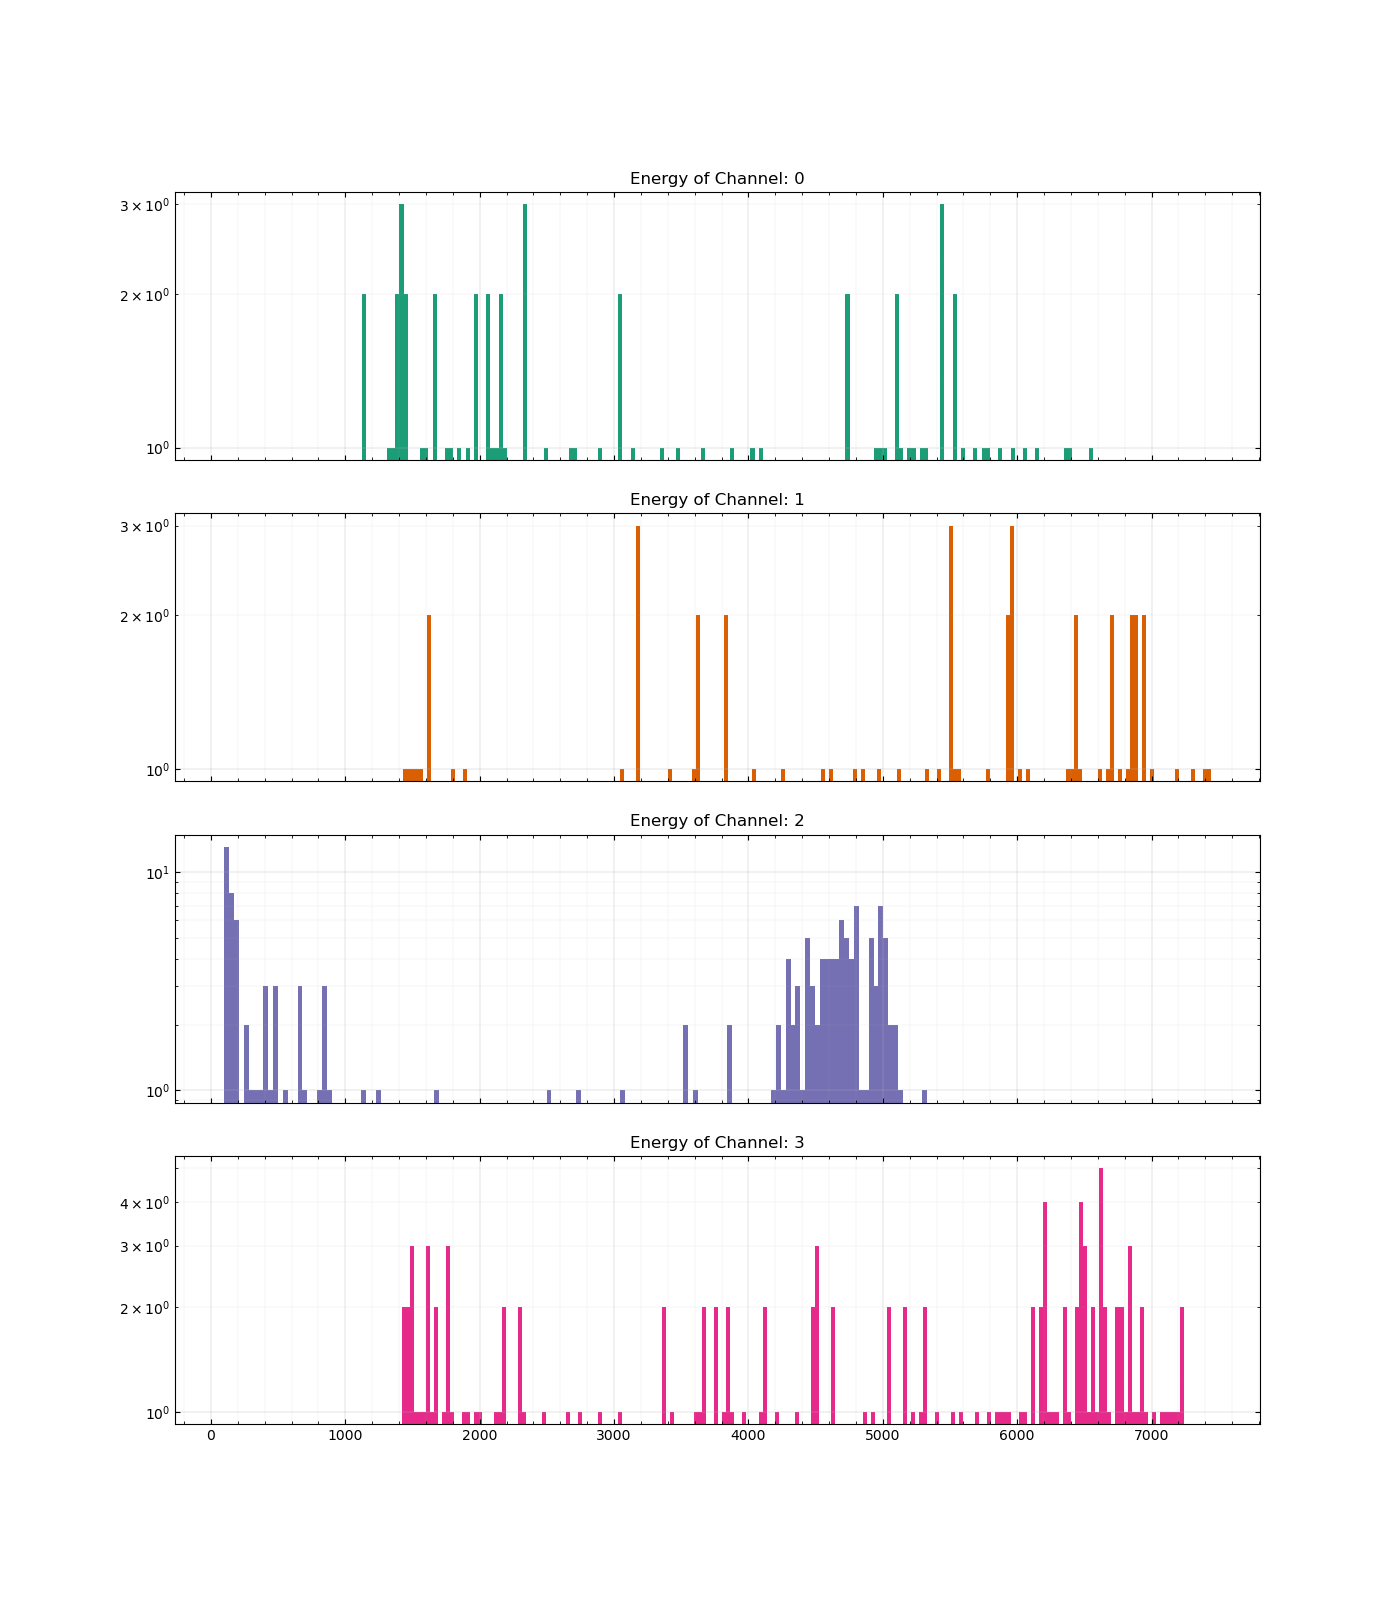

In [11]:
# Plot spectra of particular detector configuration
detectors   = [0,3]
mask        = encode_veto(detectors)

# Get small plot
f1, ax1 = detector_illustration(veto_mask=mask,LINE=False)

# Get the other plot
fig, ax = rp.plot_hists(mask_filter(mask,data), rp.VETO_STRUCT,bins=201)